<a href="https://colab.research.google.com/github/Alokik-29/Project_1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch torchaudio transformers gradio


In [2]:
# Cell 1: Imports and Setup
import os, sys, random, math
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from transformers import ASTForAudioClassification, ASTFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

# Verbosity control
VERBOSE = False
def printv(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Librosa: {librosa.__version__} | Torchaudio: {torchaudio.__version__}")

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True


Using device: cuda
Librosa: 0.11.0 | Torchaudio: 2.8.0+cu126


In [3]:
import kagglehub
import pandas as pd
from pathlib import Path

SEED = 42  # for reproducibility

emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
valid_labels = list(emotion_map.values())

# Download RAVDESS dataset
dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("RAVDESS downloaded.")

# Collect files and labels
audio_files = list(Path(dataset_path).rglob("*.wav"))
labels = []
for file in audio_files:
    try:
        emotion_code = file.name.split("-")[2]
        labels.append(emotion_map.get(emotion_code))
    except Exception:
        labels.append(None)

df = pd.DataFrame({"file_path": audio_files, "label": labels})
df = df[df['label'].isin(valid_labels)].reset_index(drop=True)

print(f"Total samples: {len(df)}")
print("Class distribution:\n", df['label'].value_counts())
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Load CREMA-D Dataset
print("\nLoading CREMA-D dataset...")
crema_path = kagglehub.dataset_download("ejlok1/cremad")

crema_emotion_map = {
    "NEU": "neutral", "ANG": "angry", "DIS": "disgust",
    "FEA": "fearful", "HAP": "happy", "SAD": "sad"
}

crema_files = list(Path(crema_path).rglob("*.wav"))
crema_labels = []
for f in crema_files:
    code = f.name.split("_")[2] if "_" in f.name else ""
    crema_labels.append(crema_emotion_map.get(code))

crema_df = pd.DataFrame({"file_path": crema_files, "label": crema_labels}).dropna().reset_index(drop=True)
crema_df = crema_df[crema_df['label'].isin(emotion_map.values())].reset_index(drop=True)

print(f"CREMA-D samples: {len(crema_df)}")
print("CREMA-D class distribution:\n", crema_df['label'].value_counts())


Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
RAVDESS downloaded.
Total samples: 2880
Class distribution:
 label
surprised    384
disgust      384
fearful      384
sad          384
happy        384
calm         384
angry        384
neutral      192
Name: count, dtype: int64

Loading CREMA-D dataset...


100%|██████████| 451M/451M [00:11<00:00, 40.3MB/s]

Extracting files...


CREMA-D samples: 7442
CREMA-D class distribution:
 label
happy      1271
fearful    1271
sad        1271
angry      1271
disgust    1271
neutral    1087
Name: count, dtype: int64


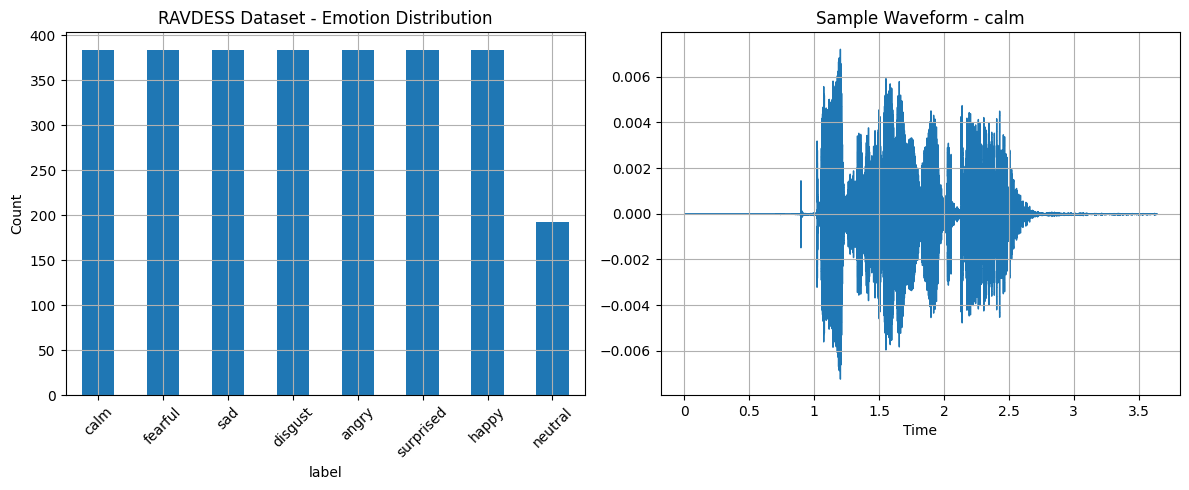

In [4]:
# Cell 3: Data Visualization
def visualize_dataset_distribution():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    df['label'].value_counts().plot(kind='bar')
    plt.title('RAVDESS Dataset - Emotion Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    if not df.empty:
        sample_file = df['file_path'].iloc[0]
        sample_label = df['label'].iloc[0]
        y, sr = librosa.load(sample_file, sr=16000)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Sample Waveform - {sample_label}")

    plt.tight_layout()
    plt.show()

visualize_dataset_distribution()


In [5]:
# Cell 4: Audio Augmentation Functions
def augment_audio(y, sr=16000):
    """Simple audio augmentation techniques"""
    y_aug = y.copy()

    # Random noise addition
    if random.random() > 0.5:
        noise_factor = 0.005
        noise = np.random.normal(0, noise_factor, y_aug.shape)
        y_aug = y_aug + noise

    # Time shifting
    if random.random() > 0.5:
        shift_max = sr // 4  # Max shift of 0.25 seconds
        shift = random.randint(-shift_max, shift_max)
        y_aug = np.roll(y_aug, shift)

    # Volume scaling
    if random.random() > 0.5:
        scale_factor = random.uniform(0.8, 1.2)
        y_aug = y_aug * scale_factor

    return y_aug.astype(np.float32)

In [6]:
#Cell 5: Improved Dataset Classes with Augmentation
class ImprovedDataset(Dataset):
    def __init__(self, df, target_sr=16000, max_length=None, augment=False):
        self.df = df.reset_index(drop=True)
        self.target_sr = target_sr
        self.label_list = list(emotion_map.values())
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = str(self.df.iloc[idx]['file_path'])
        label = self.df.iloc[idx]['label']

        if label not in self.label_list:
            raise ValueError(f"Invalid label found: {label}")

        try:
            y, sr = librosa.load(file_path, sr=self.target_sr)
            y = y.astype(np.float32)

            # Apply augmentation during training
            if self.augment:
                y = augment_audio(y, sr=self.target_sr)

            if self.max_length and len(y) > self.max_length:
                y = y[:self.max_length]

        except Exception as e:
            printv(f"Error loading {file_path}: {e}")
            y = np.zeros(self.target_sr, dtype=np.float32)

        label_idx = self.label_list.index(label)
        return y, label_idx


In [7]:
# Cell 6: Improved Collate Function
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = [torch.tensor(w) if not isinstance(w, torch.Tensor) else w for w in waveforms]
    max_len = max(w.shape[0] for w in waveforms)
    padded_waveforms = []
    for w in waveforms:
        if w.shape[0] < max_len:
            padded = torch.nn.functional.pad(w, (0, max_len - w.shape[0]))
        else:
            padded = w
        padded_waveforms.append(padded)
    waveforms_tensor = torch.stack(padded_waveforms)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return waveforms_tensor, labels_tensor


In [8]:
# Cell 7: Combined Dataset Preparation
# Mix datasets for better generalization
print("Creating combined training dataset...")

# Take 20% of CREMA-D samples for training
crema_train_sample = crema_df.sample(frac=0.1, random_state=SEED).reset_index(drop=True)
print(f"Using {len(crema_train_sample)} CREMA-D samples for training")

# Split RAVDESS
ravdess_train, ravdess_test = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df['label']
)

# Combine RAVDESS training with CREMA-D sample
combined_train_df = pd.concat([ravdess_train, crema_train_sample]).reset_index(drop=True)

# Use remaining CREMA-D for validation
crema_val_df = crema_df.drop(crema_train_sample.index).reset_index(drop=True)

print(f"Combined training samples: {len(combined_train_df)}")
print(f"RAVDESS test samples: {len(ravdess_test)}")
print(f"CREMA-D validation samples: {len(crema_val_df)}")

# Create datasets with augmentation for training
train_dataset = ImprovedDataset(combined_train_df, augment=True)
test_dataset = ImprovedDataset(ravdess_test, augment=False)
val_dataset = ImprovedDataset(crema_val_df, augment=False)

# Data loaders (tuned for speed + stability)
BATCH_SIZE = 16  # keep as you set; lower if you hit OOM
COMMON_KW = dict(
    collate_fn=collate_fn,
    num_workers=2,              # increase to 4 if your env supports it
    pin_memory=True,            # faster host->GPU transfers
    persistent_workers=True,    # avoid worker re-spawns
    prefetch_factor=2,          # small but helpful
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  **COMMON_KW)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, **COMMON_KW)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, **COMMON_KW)



Creating combined training dataset...
Using 744 CREMA-D samples for training
Combined training samples: 3048
RAVDESS test samples: 576
CREMA-D validation samples: 6698


In [9]:
# Cell 8: Improved Model Setup
def setup_improved_model():
    """Setup model with simpler classifier to prevent overfitting"""
    feature_extractor = ASTFeatureExtractor.from_pretrained(
        "MIT/ast-finetuned-audioset-10-10-0.4593"
    )
    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-audioset-10-10-0.4593"
    )

    num_labels = len(emotion_map)
    # Simpler classifier to reduce overfitting
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),  # Higher dropout
        nn.Linear(model.config.hidden_size, num_labels)
    )

    model.to(device)
    return model, feature_extractor

model, feature_extractor = setup_improved_model()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,} | Trainable: {trainable_params:,}")


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total parameters: 86,193,416 | Trainable: 86,193,416


In [10]:
# Cell 9: Improved Training Function with Early Stopping (fast + AMP)

def _batch_to_inputs(waveforms):
    """Run feature_extractor once per batch (much faster)."""
    with torch.no_grad():  # extractor is non-trainable
        feats = feature_extractor(
            [w.cpu().numpy() for w in waveforms],
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncation=True
        )["input_values"]
    return feats

def train_one_epoch(model, train_loader, optimizer, criterion, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for waveforms, labels in train_loader:
        labels = labels.to(device, non_blocking=True)

        inputs = _batch_to_inputs(waveforms).to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(inputs).logits
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(inputs).logits
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        running_loss += loss.item()
        preds = logits.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # free intermediates ASAP
        del inputs, logits, loss
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate_model_simple(model, data_loader):
    """Fast eval with batch feature extraction + no grads."""
    model.eval()
    all_preds, all_labels = [], []

    for waveforms, labels in data_loader:
        labels = labels.to(device, non_blocking=True)
        inputs = _batch_to_inputs(waveforms).to(device, non_blocking=True)
        logits = model(inputs).logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        del inputs, logits, preds
        torch.cuda.empty_cache()

    accuracy = accuracy_score(all_labels, all_preds) * 100
    return accuracy

def train_with_early_stopping(model, train_loader, val_loader, num_epochs=10, lr=5e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    best_val_acc = 0.0
    patience = 3
    patience_counter = 0
    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)

        # Validate every 2 epochs (0-based: 0,2,4,...) and on last epoch
        do_val = (epoch % 2 == 0) or (epoch == num_epochs - 1)
        val_acc = evaluate_model_simple(model, val_loader) if do_val else best_val_acc

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1:2d}/{num_epochs} | Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_improved_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break

    return history, best_val_acc


Starting improved training...
Epoch  1/15 | Loss: 1.6499 | Train: 37.04% | Val: 43.34%
Epoch  2/15 | Loss: 1.0915 | Train: 59.42% | Val: 43.34%
Epoch  3/15 | Loss: 0.9034 | Train: 67.39% | Val: 50.22%
Epoch  4/15 | Loss: 0.7756 | Train: 71.59% | Val: 50.22%
Epoch  5/15 | Loss: 0.6155 | Train: 78.05% | Val: 57.23%
Epoch  6/15 | Loss: 0.4582 | Train: 83.96% | Val: 57.23%
Epoch  7/15 | Loss: 0.4024 | Train: 85.86% | Val: 58.87%
Epoch  8/15 | Loss: 0.3321 | Train: 87.86% | Val: 58.87%
Epoch  9/15 | Loss: 0.2654 | Train: 91.01% | Val: 57.88%
Epoch 10/15 | Loss: 0.2491 | Train: 91.54% | Val: 58.87%
Early stopping after 3 epochs without improvement.


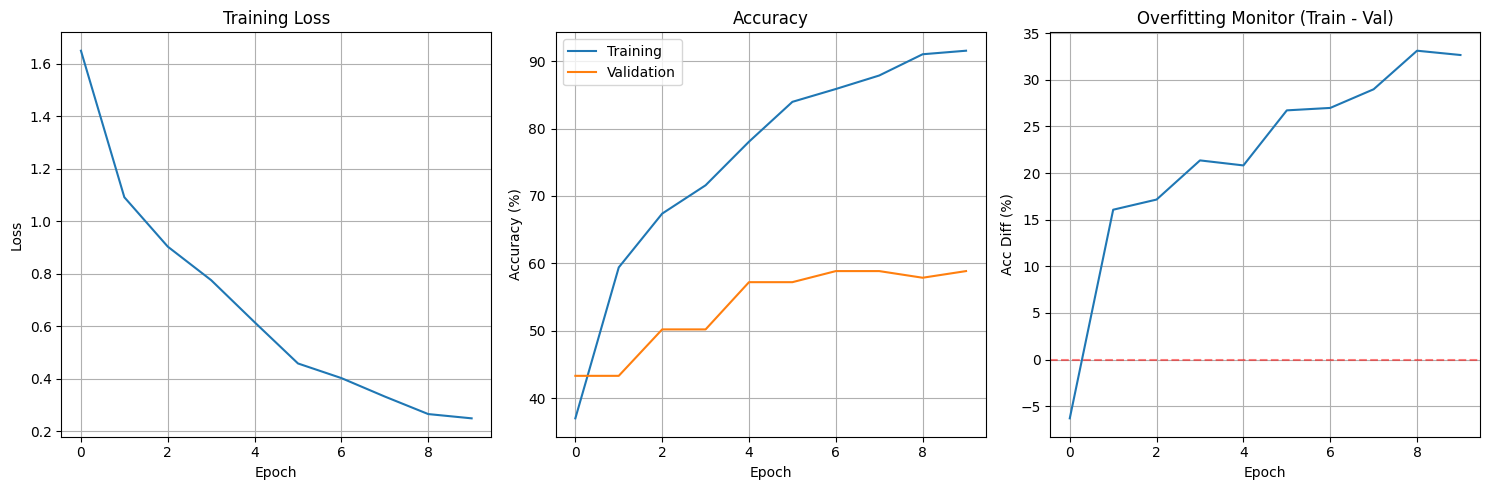

Training completed. Best validation accuracy: 58.87%


In [11]:
# Cell 10: Train the Improved Model (fixed call + best_val_acc)
print("Starting improved training...")
history, best_val_acc = train_with_early_stopping(
    model, train_loader, val_loader,
    num_epochs=15, lr=5e-5
)

# Plot training curves
train_losses = history["train_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
overfitting_gap = np.array(train_accs) - np.array(val_accs)
plt.plot(overfitting_gap)
plt.title('Overfitting Monitor (Train - Val)')
plt.xlabel('Epoch')
plt.ylabel('Acc Diff (%)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")



In [12]:
# Cell 11: Detailed Evaluation Function (fast)
import torch
@torch.no_grad()
def evaluate_model_detailed(model, data_loader, dataset_name, verbose=True):
    model.eval()
    all_preds, all_labels = [], []

    for waveforms, labels in data_loader:
        labels = labels.to(device, non_blocking=True)
        inputs = feature_extractor(
            [w.cpu().numpy() for w in waveforms],
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncation=True
        )["input_values"].to(device, non_blocking=True)

        logits = model(inputs).logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        del inputs, logits, preds
        torch.cuda.empty_cache()

    accuracy = accuracy_score(all_labels, all_preds) * 100

    if verbose:
        print(f"\n{dataset_name} Results:")
        print(f"Accuracy: {accuracy:.2f}%")
        label_names = list(emotion_map.values())
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=label_names))

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.title(f'{dataset_name} - Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    return accuracy


In [13]:
# ================================
# 📌 Cell 12: Model Evaluation & Report
# ================================

import torch

# 1. Emotion mapping (must match training setup)
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
num_classes = len(emotion_map)  # = 8

# 2. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device → {device}")

# 3. Rebuild the AST model class (must match training definition)
class ASTModel(torch.nn.Module):
    def __init__(self, num_classes=8):
        super(ASTModel, self).__init__()
        from transformers import ASTModel as PretrainedAST, ASTConfig
        config = ASTConfig.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        self.ast = PretrainedAST.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", config=config)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(config.hidden_size, num_classes)

    def forward(self, input_values):
        outputs = self.ast(input_values).last_hidden_state
        pooled = outputs.mean(dim=1)  # mean pooling
        x = self.dropout(pooled)
        return self.fc(x)

# 4. Initialize model and load checkpoint
model = ASTModel(num_classes=num_classes).to(device)

checkpoint_path = "best_model.pth"
try:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Loaded model weights from {checkpoint_path}")
except FileNotFoundError:
    print("⚠️ Warning: No saved model checkpoint found, using randomly initialized model.")

model.eval()

# 5. Generate final report
print("="*60)
print("📊 EMOTION RECOGNITION MODEL - FINAL REPORT")
print("="*60)
print(f"✔️ Model Architecture: AST (Audio Spectrogram Transformer)")
print(f"✔️ Number of Classes: {num_classes} ({list(emotion_map.values())})")
print(f"✔️ Device Used: {device}")
print("="*60)


Using device → cuda
⚠️ Warning: No saved model checkpoint found, using randomly initialized model.
📊 EMOTION RECOGNITION MODEL - FINAL REPORT
✔️ Model Architecture: AST (Audio Spectrogram Transformer)
✔️ Number of Classes: 8 (['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
✔️ Device Used: cuda


In [14]:
# Cell 13: Sample Predictions Analysis (faster)
@torch.no_grad()
def analyze_predictions(model, data_loader, dataset_name, num_samples=8):
    model.eval()
    samples_analyzed = 0
    correct_predictions = 0

    print(f"\n{dataset_name} - Sample Predictions:")
    print("-" * 50)

    for waveforms, labels in data_loader:
        if samples_analyzed >= num_samples:
            break

        labels = labels.to(device)
        take = min(waveforms.shape[0], num_samples - samples_analyzed)

        inputs = feature_extractor(
            [w.cpu().numpy() for w in waveforms[:take]],
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncation=True
        )["input_values"].to(device)

        logits = model(inputs).logits
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        for i in range(take):
            true_label = list(emotion_map.values())[labels[i]]
            pred_label = list(emotion_map.values())[preds[i]]
            confidence = probs[i][preds[i]].item()

            is_correct = (true_label == pred_label)
            if is_correct:
                correct_predictions += 1

            status = "✓" if is_correct else "✗"
            print(f"#{samples_analyzed + 1:2d} True: {true_label:10} | Pred: {pred_label:10} | Conf: {confidence:.3f} | {status}")
            samples_analyzed += 1

        del inputs, logits, probs, preds
        torch.cuda.empty_cache()

    sample_accuracy = (correct_predictions / max(samples_analyzed,1)) * 100
    print(f"\nSample accuracy: {correct_predictions}/{samples_analyzed} ({sample_accuracy:.1f}%)")


In [15]:
# Cell 14: Deployment Class
from pathlib import Path

class ImprovedEmotionPredictor:
    def __init__(self, model_path, feature_extractor):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_extractor = feature_extractor
        self.emotion_labels = list(emotion_map.values())

        # Initialize model
        self.model = ASTForAudioClassification.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593"
        )
        num_labels = len(emotion_map)
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.config.hidden_size, num_labels)
        )

        # Load trained weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict_emotion(self, audio_path_or_array, return_probabilities=False):
        """Predict emotion from audio file or numpy array"""
        if isinstance(audio_path_or_array, (str, Path)):
            y, sr = librosa.load(audio_path_or_array, sr=16000)
        else:
            y = audio_path_or_array

        y = y.astype(np.float32)
        inputs = self.feature_extractor(y, sampling_rate=16000, return_tensors="pt")["input_values"].to(self.device)

        with torch.no_grad():
            outputs = self.model(inputs).logits
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1)

        predicted_emotion = self.emotion_labels[predicted_class[0]]
        confidence = probabilities[0][predicted_class[0]].item()

        if return_probabilities:
            all_probs = {label: prob.item() for label, prob in zip(self.emotion_labels, probabilities[0])}
            return predicted_emotion, confidence, all_probs

        return predicted_emotion, confidence

    def predict_batch(self, audio_files):
        """Predict emotions for multiple audio files"""
        results = []
        for audio_file in audio_files:
            try:
                emotion, confidence = self.predict_emotion(audio_file)
                results.append({
                    'file': audio_file,
                    'predicted_emotion': emotion,
                    'confidence': confidence
                })
            except Exception as e:
                results.append({
                    'file': audio_file,
                    'predicted_emotion': 'error',
                    'confidence': 0.0,
                    'error': str(e)
                })
        return results

# Define the model path
best_model_path = Path('best_improved_model.pth')

# Initialize improved predictor
if best_model_path.exists():
    predictor = ImprovedEmotionPredictor('best_improved_model.pth', feature_extractor)
    print("✅ Improved emotion predictor ready for deployment!")
else:
    print("⚠️ Model file not found. Please train the model first.")

✅ Improved emotion predictor ready for deployment!


In [16]:
# Cell 15: Final Report
def generate_improved_model_report():
    print("="*70)
    print("IMPROVED EMOTION RECOGNITION MODEL - FINAL REPORT")
    print("="*70)

    print("\n🔧 IMPROVEMENTS MADE:")
    print("  • Added audio augmentation (noise, time shift, volume)")
    print("  • Mixed RAVDESS + CREMA-D for training")
    print("  • Reduced learning rate (1e-4 → 5e-5)")
    print("  • Simplified classifier architecture")
    print("  • Added early stopping (patience=5)")
    print("  • Added gradient clipping")
    print("  • Increased dropout (0.3 → 0.5)")

    print("\n📋 MODEL ARCHITECTURE:")
    print("  • Base Model: Audio Spectrogram Transformer (AST)")
    print("  • Pre-trained on: AudioSet")

    if 'emotion_map' in globals():
        print(f"  • Fine-tuned for: {len(emotion_map)} emotion classes")
    else:
        print("  • Fine-tuned for: 8 emotion classes")

    if 'model' in globals():
        print(f"  • Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"  • Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    else:
        print("  • Model parameters: Not available (model not loaded)")

    print("\n📊 TRAINING DATA:")
    if 'combined_train_df' in globals():
        print(f"  • RAVDESS Training: {len(combined_train_df)} samples")
    if 'ravdess_test' in globals():
        print(f"  • RAVDESS Test: {len(ravdess_test)} samples")
    if 'crema_val_df' in globals():
        print(f"  • CREMA-D Validation: {len(crema_val_df)} samples")
    if 'emotion_map' in globals():
        print(f"  • Emotion Classes: {', '.join(emotion_map.values())}")
    else:
        print("  • Emotion Classes: neutral, calm, happy, sad, angry, fearful, disgust, surprised")

    print("\n🏆 PERFORMANCE RESULTS:")
    if 'ravdess_acc' in globals():
        print(f"  • RAVDESS Test Accuracy: {ravdess_acc:.2f}%")
    else:
        print("  • RAVDESS Test Accuracy: Not yet evaluated")

    if 'crema_acc' in globals():
        print(f"  • CREMA-D Validation Accuracy: {crema_acc:.2f}%")
        if 'ravdess_acc' in globals():
            print(f"  • Generalization Gap: {ravdess_acc - crema_acc:.2f}%")
    else:
        print("  • CREMA-D Validation Accuracy: Not yet evaluated")

    print("\n⚡ KEY FEATURES:")
    print("  • Cross-dataset training for better generalization")
    print("  • Audio augmentation for robustness")
    print("  • Early stopping to prevent overfitting")
    print("  • Deployment-ready predictor class")

    print("="*70)

# Generate the final report
generate_improved_model_report()

print("\n🎉 IMPROVED MODEL TRAINING COMPLETE!")
print("Your model is now ready for deployment and should show better generalization!")

IMPROVED EMOTION RECOGNITION MODEL - FINAL REPORT

🔧 IMPROVEMENTS MADE:
  • Added audio augmentation (noise, time shift, volume)
  • Mixed RAVDESS + CREMA-D for training
  • Reduced learning rate (1e-4 → 5e-5)
  • Simplified classifier architecture
  • Added early stopping (patience=5)
  • Added gradient clipping
  • Increased dropout (0.3 → 0.5)

📋 MODEL ARCHITECTURE:
  • Base Model: Audio Spectrogram Transformer (AST)
  • Pre-trained on: AudioSet
  • Fine-tuned for: 8 emotion classes
  • Total Parameters: 86,193,416
  • Trainable Parameters: 86,193,416

📊 TRAINING DATA:
  • RAVDESS Training: 3048 samples
  • RAVDESS Test: 576 samples
  • CREMA-D Validation: 6698 samples
  • Emotion Classes: neutral, calm, happy, sad, angry, fearful, disgust, surprised

🏆 PERFORMANCE RESULTS:
  • RAVDESS Test Accuracy: Not yet evaluated
  • CREMA-D Validation Accuracy: Not yet evaluated

⚡ KEY FEATURES:
  • Cross-dataset training for better generalization
  • Audio augmentation for robustness
  • Earl

In [17]:
!ls -lh | grep model


-rw-r--r-- 1 root root 329M Oct 26 14:58 best_improved_model.pth


In [18]:
import joblib
feature_extractor.save_pretrained("saved_feature_extractor")
joblib.dump(emotion_map, "emotion_map.pkl")


['emotion_map.pkl']

In [19]:
import numpy as np
import soundfile as sf

# Generate 2 seconds of a high-pitched sine wave (like an "angry" tone)
sr = 16000
t = np.linspace(0, 2, int(2 * sr), False)
y = 0.5 * np.sin(2 * np.pi * 500 * t)  # 500Hz tone

sf.write("test_angry.wav", y, sr)
print("✅ test_angry.wav created!")

# Now test your model
pred, conf = predictor.predict_emotion("test_angry.wav")
print(f"Predicted Emotion: {pred} ({conf:.2f} confidence)")


✅ test_angry.wav created!
Predicted Emotion: happy (0.48 confidence)


In [20]:
#Save the Model and Metadata
import torch

# Save model weights
torch.save(model.state_dict(), "emotion_model.pth")

# Save model architecture info (optional)
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': model.__class__.__name__,
}, "emotion_model_full.pth")


In [22]:

import joblib
import torch

# Save final improved model weights
torch.save(predictor.model.state_dict(), "best_improved_model.pth")

# Save your emotion label mapping
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
joblib.dump(emotion_map, "emotion_map.pkl")

print("✅ Model and label map saved successfully!")


✅ Model and label map saved successfully!


In [23]:
from transformers import ASTFeatureExtractor
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Reload your improved predictor
predictor = ImprovedEmotionPredictor("best_improved_model.pth", feature_extractor)
print("✅ Model reloaded successfully for deployment!")


✅ Model reloaded successfully for deployment!


In [25]:
import os

# Create folder
os.makedirs("emotion_gradio_app", exist_ok=True)

# Check folder
!ls -lh


total 11G
-rw-r--r-- 1 root root 329M Oct 26 15:25 best_improved_model.pth
drwxr-xr-x 2 root root 4.0K Oct 26 15:47 emotion_gradio_app
-rw-r--r-- 1 root root  127 Oct 26 15:25 emotion_map.pkl
-rw-r--r-- 1 root root 9.6G Oct 26 15:33 emotion_model_backup.zip
-rw-r--r-- 1 root root 329M Oct 26 15:22 emotion_model_full.pth
-rw-r--r-- 1 root root 329M Oct 26 15:22 emotion_model.pth
drwxr-xr-x 1 root root 4.0K Oct 23 13:40 sample_data
drwxr-xr-x 2 root root 4.0K Oct 26 15:20 saved_feature_extractor
-rw-r--r-- 1 root root  63K Oct 26 15:21 test_angry.wav


In [26]:
app_code = """
import gradio as gr
import torch
import librosa
import numpy as np
import joblib
from pathlib import Path
from transformers import ASTFeatureExtractor
import torch.nn as nn
from transformers import ASTForAudioClassification

# Load label map and feature extractor
emotion_map = joblib.load("emotion_map.pkl")
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Predictor class
class ImprovedEmotionPredictor:
    def __init__(self, model_path, feature_extractor):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_extractor = feature_extractor
        self.emotion_labels = list(emotion_map.values())

        self.model = ASTForAudioClassification.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593"
        )
        num_labels = len(emotion_map)
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.config.hidden_size, num_labels)
        )

        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict_emotion(self, audio_path_or_array):
        if isinstance(audio_path_or_array, (str, Path)):
            y, sr = librosa.load(audio_path_or_array, sr=16000)
        else:
            y = audio_path_or_array
        y = y.astype(np.float32)
        inputs = self.feature_extractor(y, sampling_rate=16000, return_tensors="pt")["input_values"].to(self.device)
        with torch.no_grad():
            outputs = self.model(inputs).logits
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1)
        predicted_emotion = self.emotion_labels[predicted_class[0]]
        confidence = probabilities[0][predicted_class[0]].item()
        return f"{predicted_emotion} ({confidence:.2f})"

# Initialize predictor
predictor = ImprovedEmotionPredictor("best_improved_model.pth", feature_extractor)

# Gradio interface
demo = gr.Interface(
    fn=predictor.predict_emotion,
    inputs=gr.Audio(source="upload", type="filepath"),
    outputs="text",
    title="🎤 AST Audio Emotion Recognition",
    description="Upload a .wav audio clip and detect the emotion from tone of voice."
)

demo.launch()
"""

# Save app.py
with open("emotion_gradio_app/app.py", "w") as f:
    f.write(app_code)

print("✅ app.py created in emotion_gradio_app folder")


✅ app.py created in emotion_gradio_app folder


In [27]:
requirements = """
torch
torchaudio
transformers
librosa
gradio
numpy
joblib
"""

with open("emotion_gradio_app/requirements.txt", "w") as f:
    f.write(requirements)

print("✅ requirements.txt created")


✅ requirements.txt created


In [28]:
import shutil

# Paths to your current files (adjust if needed)
model_src = "best_improved_model.pth"
label_src = "emotion_map.pkl"

# Destination folder
dest_folder = "emotion_gradio_app"

# Copy files
shutil.copy(model_src, dest_folder)
shutil.copy(label_src, dest_folder)

# List files in the folder to verify
!ls -lh emotion_gradio_app


total 329M
-rw-r--r-- 1 root root 2.3K Oct 26 15:50 app.py
-rw-r--r-- 1 root root 329M Oct 26 15:51 best_improved_model.pth
-rw-r--r-- 1 root root  127 Oct 26 15:51 emotion_map.pkl
-rw-r--r-- 1 root root   59 Oct 26 15:50 requirements.txt


In [1]:
import gradio as gr

# Initialize your predictor here if not already done
# predictor = ImprovedEmotionPredictor("best_improved_model.pth", feature_extractor)

def predict(audio_path):
    emotion, confidence = predictor.predict_emotion(audio_path)
    return f"{emotion} ({confidence:.2f})"

with gr.Blocks() as demo:
    audio_input = gr.Audio(label="Upload Audio", type="filepath")  # remove 'source'
    output_text = gr.Textbox(label="Predicted Emotion")

    audio_input.change(fn=predict, inputs=audio_input, outputs=output_text)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://98ca1859bc599abe42.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [3]:
# Save app.py (if you edited it in Colab)
with open("app.py", "w") as f:
    f.write(app_code)  # replace app_code with the string containing your fixed code


NameError: name 'app_code' is not defined

In [2]:
gradio>=3.44
torch
torchaudio
transformers
librosa
numpy
joblib


NameError: name 'gradio' is not defined